In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [2]:
def load_images(dataset_path, img_size=(100,100)):
    images = []
    labels = []

    for person_dir in os.listdir(dataset_path):  #for every folder in the dataset path
        person_path = os.path.join(dataset_path, person_dir) #extend path name so it refers to the specific folders for th indv
        if not os.path.isdir(person_path):
            continue

        for img_name in os.listdir(person_path): # for every file in each individual's folder
            img_path = os.path.join(person_path, img_name)
            
            # load portable grey map file (.pmg) // grayscaled image in using cv2
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

            # resize image
            img_resized = cv2.resize(img, img_size)
            #add resized image to empty image list
            images.append(img_resized)
            labels.append(int(person_dir[1:]))

    return np.array(images), np.array(labels) #convert the lists to np arrays

In [3]:
dataset_path = "/kaggle/input/att-database-of-faces"
x, y = load_images(dataset_path, img_size = (100,100))

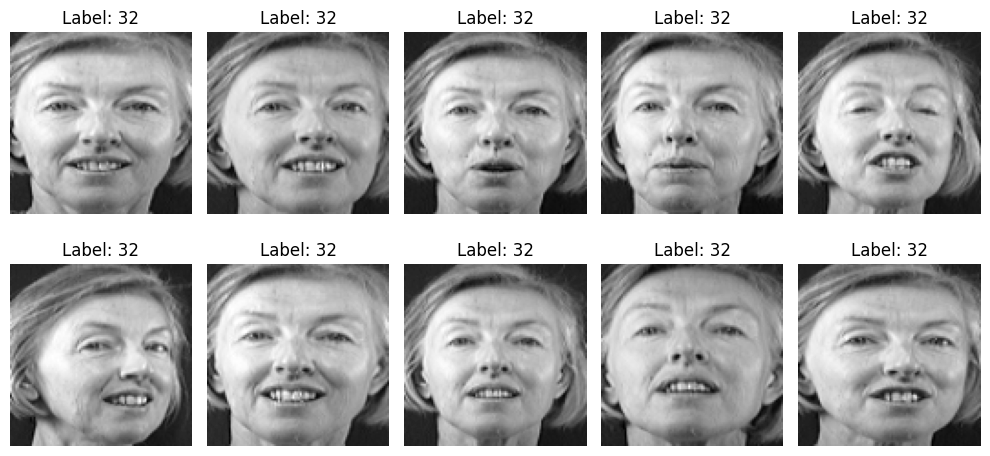

In [4]:
plt.figure(figsize=(10,5))
for i in range(10):
    plt.subplot(2,5,i+1)
    plt.imshow(x[i], cmap = 'gray')
    plt.title(f'Label: {y[i]}')
    plt.axis('off')
plt.tight_layout()
plt.show()

In [5]:
#Facial Recognition using Non-negative Matrix Factorization

n_samples, height, width = x.shape
x_flat = x.reshape(n_samples, height*width)
print(x_flat.shape) # x_flat is now observations with 10000 features

(400, 10000)


In [6]:
from sklearn.decomposition import NMF

n_components = 50

nmf = NMF(n_components=n_components, 
          init='random', 
          random_state=301, 
          max_iter = 5000,
          beta_loss = 'frobenius')

x_nmf = nmf.fit_transform(x_flat)

/usr/local/lib/python3.11/dist-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 5000 reached. Increase it to improve convergence.
  warnings.warn(


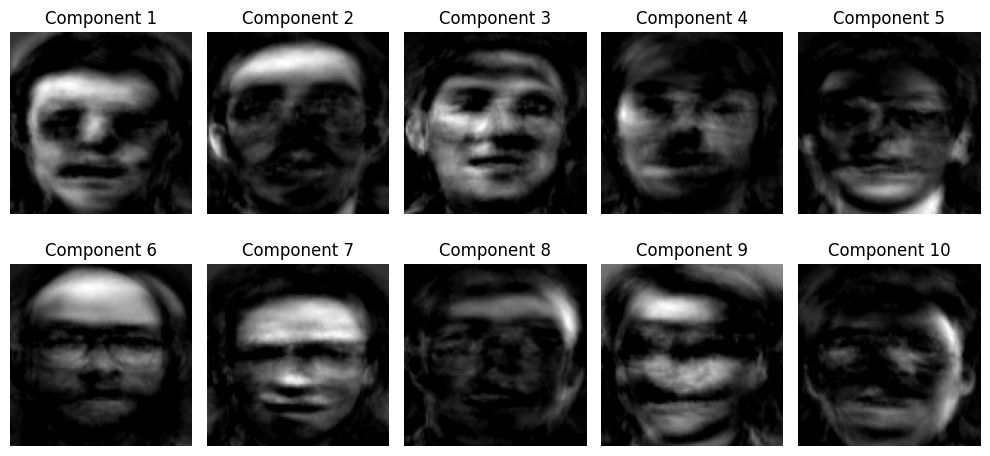

In [7]:
plt.figure(figsize = (10,5))
for i in range(10):
    plt.subplot(2,5, i+1)
    plt.imshow(nmf.components_[i].reshape(height, width), cmap = 'gray')
    plt.title(f'Component {i+1}')
    plt.axis('off')
plt.tight_layout()
plt.show()

In [8]:
x_train_flat, x_test_flat, y_train, y_test = train_test_split(
    x_flat, y, test_size=0.2, random_state=301, stratify=y
)

nmf = NMF(n_components=n_components, init='random', random_state=301, max_iter = 10000)
x_train_nmf = nmf.fit_transform(x_train_flat)
x_test_nmf = nmf.transform(x_test_flat)

In [9]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(x_train_nmf, y_train)
y_pred = knn.predict(x_test_nmf)

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")


Accuracy: 0.88


In [10]:
# Compare Full vs. Left / Top / Bottom halves
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

views = {
    "Full Face": lambda img: img,
    "Left Half": lambda img: img.reshape(height, width)[:, :width//2].flatten(),
    "Top Half":  lambda img: img.reshape(height, width)[:height//2, :].flatten(),
    "Bottom Half": lambda img: img.reshape(height, width)[height//2:, :].flatten(),
}

results = []
for name, view_fn in views.items():
    # apply view and then NMF → KNN
    X_tr = np.array([view_fn(img) for img in x_train_flat])
    X_te = np.array([view_fn(img) for img in x_test_flat])
    
    nmf = NMF(n_components=n_components, init='random', random_state=301, max_iter=5000)
    W_tr = nmf.fit_transform(X_tr)
    W_te = nmf.transform(X_te)
    
    knn = KNeighborsClassifier(n_neighbors=3)
    knn.fit(W_tr, y_train)
    acc = accuracy_score(y_test, knn.predict(W_te))
    results.append((name, acc))

# comparison
for name, acc in results:
    print(f"{name:12s} → Accuracy = {acc:.2%}")


/usr/local/lib/python3.11/dist-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 5000 reached. Increase it to improve convergence.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 5000 reached. Increase it to improve convergence.
  warnings.warn(


Full Face    → Accuracy = 87.50%
Left Half    → Accuracy = 77.50%
Top Half     → Accuracy = 80.00%
Bottom Half  → Accuracy = 77.50%


/usr/local/lib/python3.11/dist-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 5000 reached. Increase it to improve convergence.
  warnings.warn(


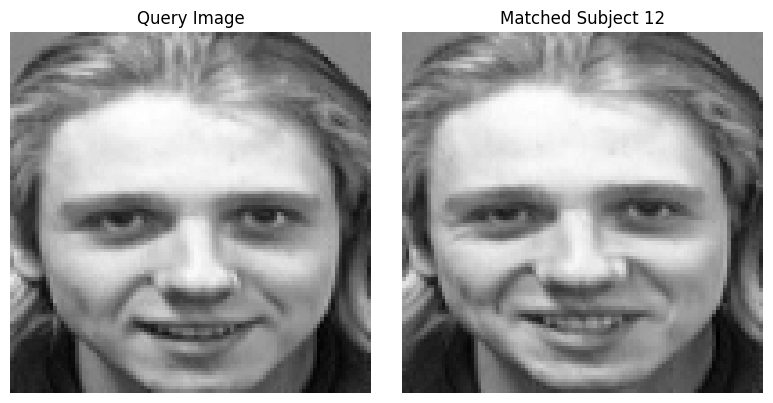

In [11]:
# ─── Normalize, split, and fit NMF on training set ───
x_flat = x_flat / 255.0
x_train_flat, x_test_flat, y_train, y_test = train_test_split(
    x_flat, y, test_size=0.2, random_state=301, stratify=y
)

nmf_full = NMF(
    n_components=n_components,
    init='random',
    random_state=301,
    max_iter=5000,
    beta_loss='frobenius'
)
W_train = nmf_full.fit_transform(x_train_flat)


# ─── Updated find_closest (skips identical training image) ───
def find_closest(img_path):
    # load & preprocess exactly as train data
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, (height, width)) / 255.0
    flat = img.flatten()[None, :]
    
    # project into the same NMF space
    W_new = nmf_full.transform(flat)                 # shape (1, n_components)
    
    # compute euclidean distances to all training codes
    dists = np.linalg.norm(W_train - W_new, axis=1)
    
    # pick the second‐smallest distance (so you skip the identical image itself)
    # argsort gives sorted indices, so [1] is the second‐closest
    idx = np.argsort(dists)[1]
    
    # return the label and the train image for display
    return y_train[idx], x_train_flat[idx].reshape(height, width)



# ─── Example usage with side‑by‑side plot ───
test_img_path = "/kaggle/input/att-database-of-faces/s12/5.pgm"
label, match_img = find_closest(test_img_path)

# load & preprocess test image again for plotting
test_img = cv2.imread(test_img_path, cv2.IMREAD_GRAYSCALE)
test_img = cv2.resize(test_img, (height, width)) / 255.0

fig, axes = plt.subplots(1, 2, figsize=(8, 4))
axes[0].imshow(test_img, cmap='gray')
axes[0].set_title("Query Image")
axes[0].axis('off')

axes[1].imshow(match_img, cmap='gray')
axes[1].set_title(f"Matched Subject {label}")
axes[1].axis('off')

plt.tight_layout()
plt.show()
